In [1]:
# imports

# pretend we are in the root folder:
import os
import sys
sys.path.append("../")

from udl_2024_package.nn import unet_factory, DiffusionNoiser
from udl_2024_package.vincent_diffusion import DiffusionModel
from udl_2024_package.datasets import remove_dataset_labels, default_img_transforms

import torch
from torchvision import datasets
from torch.utils.data import DataLoader

import lightning as L
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint
import wandb


In [2]:
# WandB config:
project_name = "udl_2025_diffusion_gan"
group_name = "experiment_00_pure_diffusion"

config = {
    # Input data and training:
    "batch_size": 256,          # Warning: change to 256 for real run
    
    "dataset_cls": datasets.CIFAR10,
        "ds_name": "cifar10",   # Warning: change when changing dataset
        "num_channels": 3,      # Warning: change when changing dataset
        "img_size": 32,         # Warning: change when changing dataset
        "extra_transforms": [], # Warning: change when changing dataset

    # "dataset_cls": datasets.MNIST,
    #     "ds_name": "mnist",     # Warning: change when changing dataset
    #     "num_channels": 1,      # Warning: change when changing dataset
    #     "img_size": 32,         # Warning: change when changing dataset
    #     "extra_transforms": [   # Warning: change when changing dataset
    #         transforms.Resize(32)
    #     ],
    
    "max_epochs": 150,
    "dl_num_workers": 4,

    # Diffusion model (DDPM paper defaults):
    "optimizer_cls": torch.optim.Adam,
    "optimizer_args": {"lr": 2e-4},
    "ddpm_steps": 1000,
    "ddpm_beta_start": 0.0001,
    "ddpm_beta_end": 0.02,

    # U-Net config:
    "block_out_channels": [128, 256, 256, 256],
    "layers_per_block": 2
}

datasets_path = os.path.join(os.environ.get("TMPDIR", os.curdir), "datasets")

dataloader_kwargs = {
    "batch_size": config["batch_size"],
    "shuffle": True,
    "num_workers": config["dl_num_workers"],
    "pin_memory": True,
}

unet = unet_factory(
    img_size=config["img_size"],
    img_channels=config["num_channels"],
    block_out_channels=config["block_out_channels"],
    layers_per_block=config["layers_per_block"]
)

In [3]:
# Loading last checkpoint:
dif_model = DiffusionModel.load_from_checkpoint("./cifar10_peachy-totem-7_epochepoch=94.ckpt",
    model=unet,
    optimizer_cls=config["optimizer_cls"],
    optimizer_args=config["optimizer_args"],
    steps=config["ddpm_steps"],
    beta_start=config["ddpm_beta_start"],
    beta_end=config["ddpm_beta_end"],
)
# dif_model.to("cpu");

In [5]:
import numpy as np
torch.manual_seed(1967)
np.random.seed(1967)

def denoising_step(noiser_self: DiffusionNoiser, img_t, noise_t, t, new_noise):
    prev_t = torch.clamp(t - 1, 0)
    
    beta = noiser_self.reshape(noiser_self.betas[t], img_t)
    alpha_bar = noiser_self.reshape(noiser_self.alpha_bars[t], img_t)
    alpha_bar_prev = noiser_self.reshape(noiser_self.alpha_bars[prev_t], img_t)

    img_0 = noiser_self.img_from_closed_form_noise(img_t, noise_t, t)
    # img_0 = img_0.clamp(-1, 1)
    
    img_0_scalar = torch.sqrt(alpha_bar_prev) * beta / (1 - alpha_bar)
    img_t_scalar = torch.sqrt(1 - beta) * (1 - alpha_bar_prev) / (1 - alpha_bar)
    mu_t = img_0_scalar * img_0 + img_t_scalar * img_t

    variance_t = beta * (1 - alpha_bar_prev) / (1 - alpha_bar)
    
    return mu_t + torch.sqrt(variance_t) * new_noise

@torch.inference_mode()
def sample_img(self: DiffusionModel, shape: tuple[int]):
    self.eval()
    noisy_img = torch.randn(shape, device=self.device)
    steps = len(self.noiser.betas)
    for idx in reversed(range(steps)):
        t = torch.tensor([idx], device=self.device)
        predicted_noise = self(noisy_img, t)
        new_noise = torch.randn_like(noisy_img)
        noisy_img = denoising_step(self.noiser, noisy_img, predicted_noise, t, new_noise)
    return noisy_img

sample = sample_img(dif_model.to("cuda"), (1, 3, 32, 32))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4844935..0.92300427].


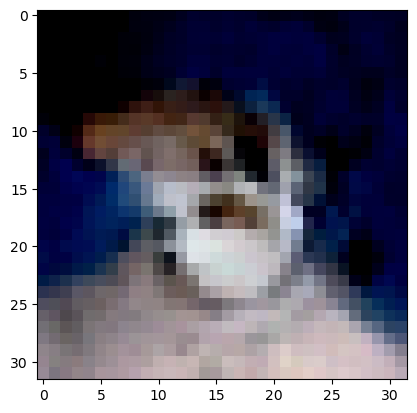

In [6]:
import matplotlib.pyplot as plt
plt.imshow(sample[0].detach().transpose(0,2).cpu() * 0.5 + 0.5)
plt.show()

## Final test
I copied the stuff over to the DiffusionNoiser class. Seeing if we get the same
output if we just call the sampling function again.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49082315..0.92217433].


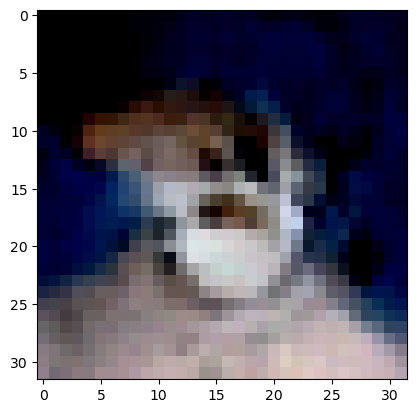

In [4]:
dif_model.to("cuda")

import numpy as np
torch.manual_seed(1967)
np.random.seed(1967)

sample = dif_model.sample_img((1, 3, 32, 32))

import matplotlib.pyplot as plt
plt.imshow(sample[0].detach().transpose(0,2).cpu() * 0.5 + 0.5)
plt.show()

## Stuff below can be ignored
There I tested what happens when I use my model with their DDPM pipeline. It
creates really nice images! So Now I will work on recreating their algorithm.

In [10]:
from diffusers import DDPMPipeline, UNet2DModel

model_id = "google/ddpm-cifar10-32"

# load model and scheduler
ddpm = DDPMPipeline.from_pretrained(model_id)

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

In [24]:
# dif_model.model.__class__.forward = UNet2DModel.forward
unet.__class__.forward = UNet2DModel.forward
ddpm.unet = unet # dif_model.model

In [25]:
ddpm.to("cuda")
images = ddpm(5).images

  0%|          | 0/1000 [00:00<?, ?it/s]

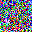

In [26]:
images[0]